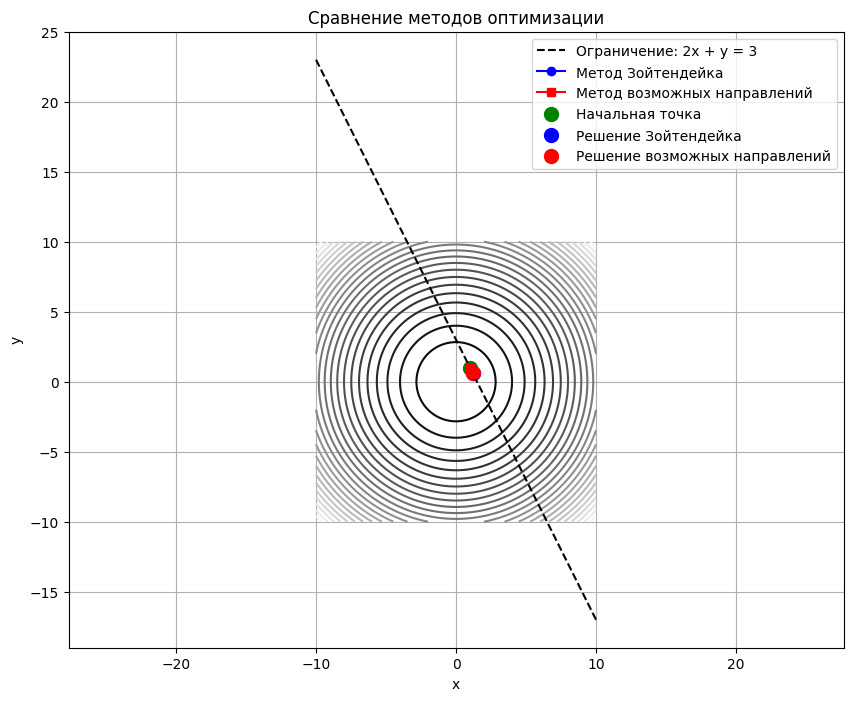

(None, array([1.20000005, 0.5999999 ]), array([1.19999719, 0.60000561]))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog, minimize_scalar, minimize

# Определение функции, ограничения и их градиентов
def f(x):
    return x[0]**2 + x[1]**2  # простая квадратичная функция

def constraint(x):
    return 2*x[0] + x[1] - 3  # линейное ограничение

def gradient_f(x):
    return np.array([2*x[0], 2*x[1]])

def gradient_constraint(x):
    return np.array([2, 1])

# Метод Зойтендейка
def zoitenjik_method(f, grad_f, constraint, grad_constraint, x0, max_iter=100, epsilon=1e-6):
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]
    
    for k in range(max_iter):
        if abs(constraint(x)) > epsilon:
            c = np.array([1, 1])
            A_eq = grad_constraint(x).reshape(1, -1)
            b_eq = np.array([constraint(x)])
            res = linprog(c, A_eq=A_eq, b_eq=b_eq)
            if res.success:
                x = x + res.x
                trajectory.append(x.copy())
                continue
        
        grad_fx = grad_f(x)
        grad_phix = grad_constraint(x)
        
        c = grad_fx.flatten()
        A_eq = grad_phix.reshape(1, -1)
        b_eq = np.array([0])
        bounds = [(-1, 1), (-1, 1)]
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        
        if not res.success:
            break
            
        d = res.x
        if np.linalg.norm(d) < epsilon:
            break
            
        alpha = 1.0
        rho = 0.5
        c = 0.1
        
        while True:
            x_new = x + alpha * d
            if (abs(constraint(x_new)) < epsilon and 
                f(x_new) < f(x) + c*alpha*np.dot(grad_fx.flatten(), d)):
                break
            alpha *= rho
            if alpha < 1e-10:
                break
                
        x = x + alpha * d
        trajectory.append(x.copy())
        
        if np.linalg.norm(alpha * d) < epsilon:
            break
            
    return x, np.array(trajectory)

# Метод возможных направлений
def feasible_direction_method(f, grad_f, constraint, grad_constraint, x0, max_iter=100, epsilon=1e-6):
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]
    
    for k in range(max_iter):
        if abs(constraint(x)) > epsilon:
            cons = {'type': 'eq', 'fun': constraint}
            res = minimize(lambda z: np.sum((z - x)**2), x, constraints=cons)
            if res.success:
                x = res.x
                trajectory.append(x.copy())
        
        grad_fx = grad_f(x)
        grad_phix = grad_constraint(x)
        
        c = grad_fx
        A_eq = grad_phix.reshape(1, -1)
        b_eq = np.array([0])
        
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(-1, 1), (-1, 1)])
        
        if not res.success:
            break
            
        d = res.x
        if np.linalg.norm(d) < epsilon:
            break
            
        def phi(alpha):
            return f(x + alpha*d)
            
        alpha_result = minimize_scalar(phi, bounds=(0, 1.0), method='bounded')
        
        if not alpha_result.success:
            break
            
        alpha = alpha_result.x
        x_new = x + alpha*d
        
        if np.linalg.norm(x_new - x) < epsilon:
            break
            
        x = x_new
        trajectory.append(x.copy())
    
    return x, np.array(trajectory)

# Начальная точка
x0 = np.array([1.0, 1.0])

# Выполнение обоих методов
sol_z, traj_z = zoitenjik_method(f, gradient_f, constraint, gradient_constraint, x0)
sol_fd, traj_fd = feasible_direction_method(f, gradient_f, constraint, gradient_constraint, x0)

# Построение графика
x_vals = np.linspace(-10, 10, 400)
y_vals = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X**2 + Y**2

plt.figure(figsize=(10, 8))
plt.contour(X, Y, Z, levels=30, cmap='gray')
plt.plot(x_vals, 3 - 2 * x_vals, 'k--', label='Ограничение: 2x + y = 3')
plt.plot(traj_z[:, 0], traj_z[:, 1], 'b-o', label='Метод Зойтендейка')
plt.plot(traj_fd[:, 0], traj_fd[:, 1], 'r-s', label='Метод возможных направлений')
plt.scatter(*x0, color='green', s=100, label='Начальная точка')
plt.scatter(*sol_z, color='blue', s=100, label='Решение Зойтендейка')
plt.scatter(*sol_fd, color='red', s=100, label='Решение возможных направлений')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение методов оптимизации')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show(), sol_z, sol_fd
